In [6]:
from agent_helpers.multi_agent import *
from agent_helpers.api_keys import *
from IPython.display import Image, display


In [2]:
openai_key = get_keys() 

In [7]:
graph =create_nodes(openai_key = openai_key)

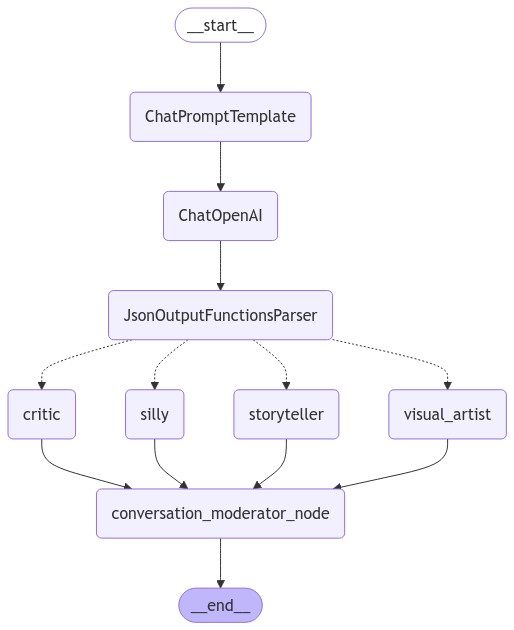

In [8]:

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# test = stream_messages(
#     graph, 
#     text="What do you think of my drawing?", 
#     thread = {"configurable": {"user_id": "1", "thread_id": "1"}},
#     image_="https://huggingface.co/datasets/jacob314159/child_drawings/resolve/main/205490118.jpeg",
# )

In [ ]:
# test

In [9]:
test = stream_messages(graph, 
                text="It is a garden with caterpillars!", 
               thread = {"configurable": {"user_id": "1", "thread_id": "1"}}, 
               image_path = "uploaded_images/family_sketch.jpg")

BadRequestError: Error code: 400 - {'error': {'message': 'Invalid content type. image_url is only supported by certain models.', 'type': 'invalid_request_error', 'param': 'messages.[1].content.[1].type', 'code': None}}

In [ ]:
test

In [ ]:
if 'conversation_moderator_node' in test:
    print(True)
else:
    print(False)
    

In [ ]:
test['conversation_moderator_node']['messages'][0].content

In [ ]:
# import base64
# from openai import OpenAI


# client = OpenAI()

# # Function to encode the image
# def encode_image(image_path):
#   with open(image_path, "rb") as image_file:
#     return base64.b64encode(image_file.read()).decode('utf-8')

# # Path to your image
# image_path = "uploaded_images/Exersize.jpg"

# # Getting the base64 string
# base64_image = encode_image(image_path)

# response = client.chat.completions.create(
#   model="gpt-4o-mini",
#   messages=[
#     {
#       "role": "user",
#       "content": [
#         {
#           "type": "text",
#           "text": "What is in this image?",
#         },
#         {
#           "type": "image_url",
#           "image_url": {
#             "url":  f"data:image/jpeg;base64,{base64_image}"
#           },
#         },
#       ],
#     }
#   ],
# )

# print(response.choices[0])

In [15]:
def stream_messages_with_routing(graph, text: str, thread: dict, image_path: str=None):
    # Phase 1: Supervisor decision (text only)
    content = [{"type": "text", "text": text}]

    # Define input for supervisor (text only)
    input_data = {
        "messages": [
            HumanMessage(content=content)
        ]
    }

    # Supervisor processing
    final_message = ""
    for s in graph.stream(input_data, config=thread):
        if "__end__" not in s:
            # Capture supervisor decision
            final_message = s

    # Get the routing decision from the supervisor's output
    if 'supervisor' in final_message:
        next_agent = final_message['supervisor']['next']  # Get which agent to route to
    else:
        print("Error: Supervisor did not return a routing decision.")
        return

    # Phase 2: Send both text and image to the routed agent
    if image_path:
        # If image_path is provided, encode the image and append to the message
        base64_image = encode_image(image_path)
        content.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
        })

    # Define the input for the next agent (text + image if present)
    input_data = {
        "messages": [
            HumanMessage(content=content)
        ]
    }

    # Agent processing
    agent_result = ""
    for s in graph.stream(input_data, config=thread):
        if "__end__" not in s:
            agent_result = s

    # Handle and display the final result
    if next_agent in agent_result:
        final_message_str = agent_result[next_agent]['messages'][0].content
    else:
        print("Error: Agent did not return a response.")
        return

    print("Final Output:", final_message_str)
    return final_message_str


In [16]:
stream_messages_with_routing(graph, 
                text="can you help me improve my drawing?", 
               thread = {"configurable": {"user_id": "1", "thread_id": "1"}}, 
               image_path = "uploaded_images/family_sketch.jpg")

BadRequestError: Error code: 400 - {'error': {'message': 'Invalid content type. image_url is only supported by certain models.', 'type': 'invalid_request_error', 'param': 'messages.[1].content.[1].type', 'code': None}}